In [1]:
import sys
sys.path.append("../")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
#import pandas as pd
import numpy as np
import cv2
from PIL import Image, ImageDraw
import random
#import tensorflow as tf
#import re
import datetime
import io
#from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import pickle
#import string
#from keras.models import Model, load_model
#from keras.layers import Input, LSTM, Dense, Conv2D, MaxPooling2D, Reshape, Dropout, BatchNormalization, Activation
#from utils import score_prediction, generate_token_index, y_labels
import yaml 
import json
from preprocessing.preproc_functions import read_image, read_query, normalize_0_1, read_annotation
from predictors.predictor import PredictorFCN
from data_generators.data_generator import DataGenerator
#from utils.score_prediction import pixel_accuracy, mean_accuracy, mean_IoU, freq_weighted_mean_IoU, score_prediction
from tensorflow.keras.models import load_model, model_from_json

from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.measure import label, regionprops
#from skimage.util.montage import montage2d as montage

%matplotlib inline

In [4]:
with open('../configs/config.yml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
    
config['labels_file'] = '../' + config['labels_file']
config['dataset_folder'] = '../' + config['dataset_folder']

config['network']['graph_path'] = '../' + config['network']['graph_path']
config['predict']['weights_file'] = '../' + config['predict']['weights_file']

y_size = config['image']['image_size']['y_size']
x_size = config['image']['image_size']['x_size']
y_query_size = config['image']['query_image_size']['y_size']
x_query_size = config['image']['query_image_size']['x_size']

In [5]:
with open(config['labels_file']) as f:
    dataset = json.load(f)

### Load model

In [6]:
json_file = open(config['network']['graph_path'], 'r')
loaded_model_json = json_file.read()
json_file.close()

model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights(config['predict']['weights_file'])

### Predict

In [7]:
items = dataset['test']

In [19]:
index = random.randint(0, len(items)-1)
elem = items[index]

query = read_query(config['dataset_folder'], elem['query'], y_query_size, x_query_size, black_white = False)
image = read_image(config['dataset_folder'], elem['image']['filename'], y_size, x_size, black_white = False)
annotation = read_annotation(config['dataset_folder'], elem['image']['annotation'], y_size, x_size)

query = normalize_0_1(query)                   
image = normalize_0_1(image) 

if elem['query']['class_num'] != elem['image']['class_num']:
    annotation[:,:] = 0.

query = np.expand_dims(query, axis=0)
image = np.expand_dims(image, axis=0)

output_prob = model.predict([query, image])
output = np.where(output_prob > 0.5, 1., 0.)

query = query[0, ...]
image = image[0, ...]
output = output[0, ...]

lbl_0 = label(output) 
props = regionprops(lbl_0)

#image_with_bbox = image.copy() * 255.
image_with_bbox = Image.fromarray(np.uint8(image * 255.))
draw = ImageDraw.Draw(image_with_bbox)

for prop in props:
#    cv2.rectangle(image_with_bbox, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2]), (255, 0, 0), 2)
    draw.rectangle(((prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2])), outline="red", width=3)
    
    
image_with_bbox = np.asarray(image_with_bbox)/255.
#image_with_bbox /= 255.
#image_with_bbox = image_with_bbox.astype(int)

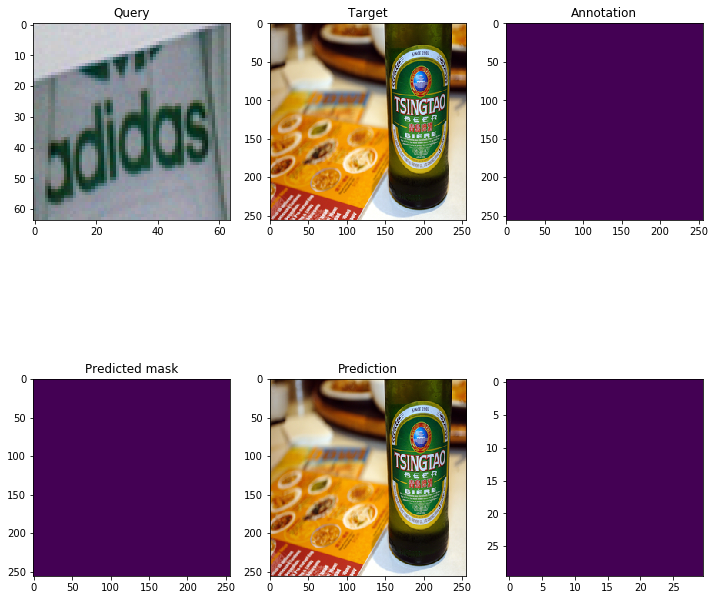

In [20]:
#index = random.randint(0, len(query)-1)
#fig = plt.figure(figsize=(15, 15))
images = []

fig, axs = plt.subplots(2, 3, figsize=(12, 12))

#plt.subplot(1, 4, 1)
axs[0, 0].set_title("Query")
images.append(axs[0, 0].imshow(query))

axs[0,1].set_title("Target")
images.append(axs[0,1].imshow(image))

axs[0,2].set_title("Annotation")
images.append(axs[0,2].imshow(annotation))

axs[1,0].set_title("Predicted mask")
images.append(axs[1,0].imshow(output))

axs[1,1].set_title("Prediction")
images.append(axs[1,1].imshow(image_with_bbox))

axs[1,2].set_title("")
images.append(axs[1,2].imshow(np.zeros((30, 30))))

### Test on unknown classes

In [ ]:
unknown_classes = os.listdir("../test_images")
#unknown_class = unknown_classes[0]
#print(unknown_class)

In [ ]:
unknown_class = unknown_classes[2]
print(unknown_class)

In [ ]:
query_filename = {"filename": unknown_class + "_query.jpg"}
image_filename = unknown_class + "2.jpg"

query = read_query('../test_images/' + unknown_class + "/", query_filename, y_query_size, x_query_size, black_white = False)
image = read_image('../test_images/' + unknown_class + "/", image_filename, y_size, x_size, black_white = False)

query = normalize_0_1(query)                   
image = normalize_0_1(image) 

query = np.expand_dims(query, axis=0)
image = np.expand_dims(image, axis=0)

output_prob = model.predict([query, image])
output = np.where(output_prob > 0.5, 1., 0.)

query = query[0, ...]
image = image[0, ...]
output = output[0, ...]

In [ ]:
images = []

fig, axs = plt.subplots(1, 3, figsize=(16, 16))
axs[0].set_title("Query")
images.append(axs[0].imshow(query))

axs[1].set_title("Target")
images.append(axs[1].imshow(image))

axs[2].set_title("Prediction")
images.append(axs[2].imshow(output))

In [ ]:
np.max(output_prob)